<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/knn_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN: Create Model
## In this notebook we will create a ensemble of KNN prediction models using the sample derived from the [KNN: Sample Design notebook](https://github.com/jshogland/SpatialModelingTutorials/blob/23955824e1fd8258776663a8204af23be9a8f727/Notebooks/knn_sample_design.ipynb)
### Objectives
- Learn about KNN
- Learn how to build an ensemble
- Apply the model to estimate CF/Acre and standard error

### Datasets [from knn_sample_desing.ipynb](https://github.com/jshogland/SpatialModelingTutorials/blob/23955824e1fd8258776663a8204af23be9a8f727/Notebooks/knn_sample_design.ipynb)
- Landsat 8 imagery(ls8.tif)
- Cubic Feet imagery (cf1.tif)
- Sample dataset (sb_sample.shp.zip): columns [ls8_1 - ls8_7 and cf]; n=150;
  - ls8 -> spectral reflectance for (blue,green,red,nir,mid_ir1,mid_ir2)
  - cf -> cubic feet of timber


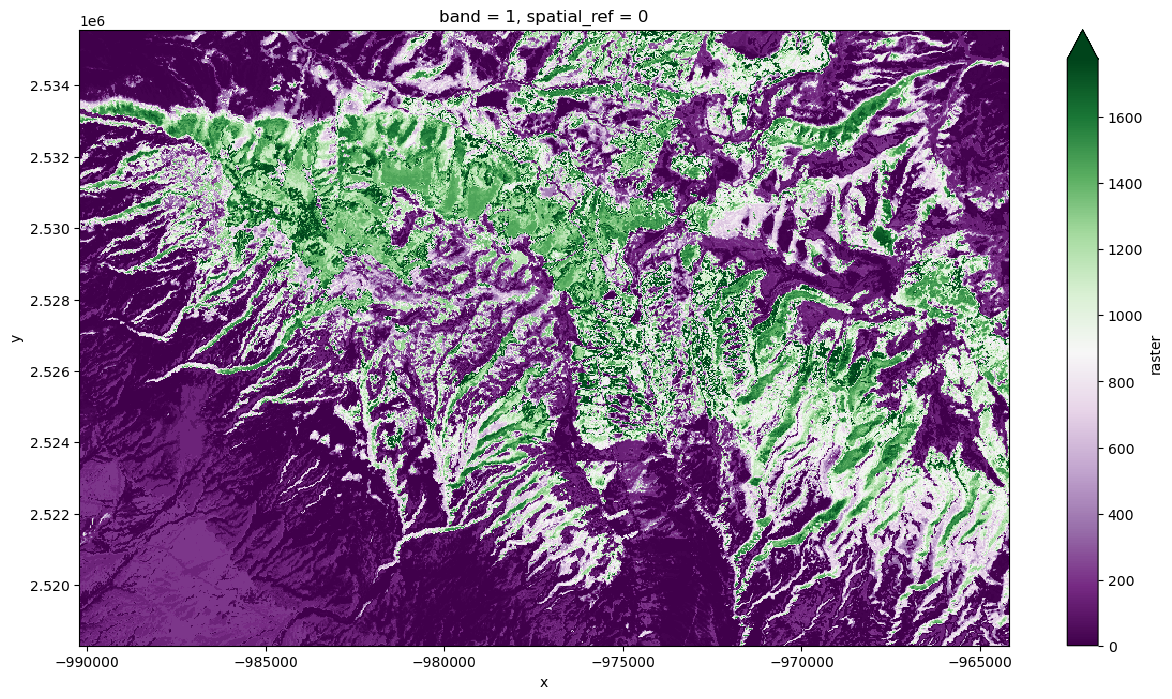

## Install packages

In [20]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools

### Steps
1. Explore the sample
2. Create a EKNN model
3. Use the EKNN to estimate CF/Acre
4. Evaluate the model

by John Hogland 3/26/2024

## Import packages

In [21]:
#get packages
from raster_tools import Raster,general,clipping
import geopandas as gpd, pandas as pd, osmnx as ox
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

## Step 1: Explore the sample
In this step we will read in the sample data and create a scatter plot matrix of the relationship among all variables. If you have not already processed the steps in the [KNN Sample Design notebook]('knn_sample_design.ipynb'), then please work through that notebook and save all outputs from that exercise before proceeding.

### Look at the study area and sample locations

In [22]:
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

# read in the data
gdf=gpd.read_file('sb_sample.shp.zip')

# map the national forest boundary and sample locations
m=nf1p.explore()
m=gdf.explore(m=m,color='yellow')
m


<ipython-input-22-d21d41a1e610>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


### Look at the relationship among variables

array([[<Axes: xlabel='ls8_1', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_6', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_7', ylabel='ls8_1'>,
        <Axes: xlabel='cf', ylabel='ls8_1'>],
       [<Axes: xlabel='ls8_1', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_6', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_7', ylabel='ls8_2'>,
        <Axes: xlabel='cf', ylabel='ls8_2'>],
       [<Axes: xlabel='ls8_1', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_3

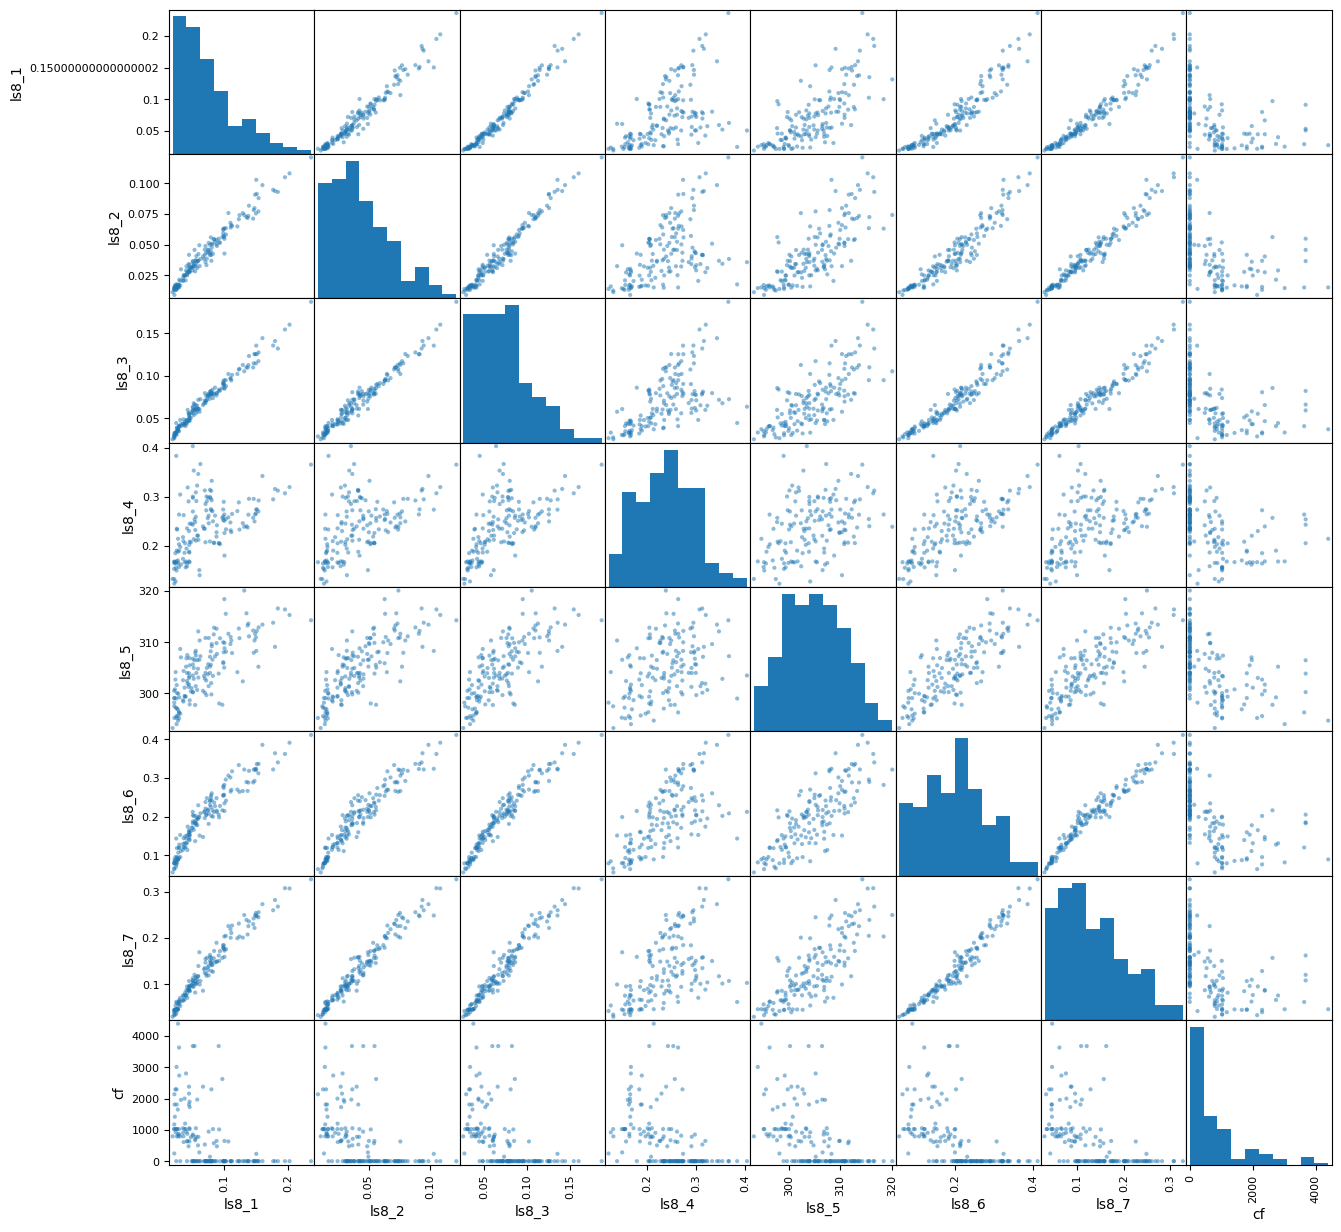

In [23]:
# get the response and predictor variables
pred=gdf.columns[:-2]

# create a scatter plot matrix of all variables
pd.plotting.scatter_matrix(gdf,figsize=(15,15))

## Step 2: Create EKNN
In this step we will transform our predictor variables into normalized independent components and then use those components to create an ensemble of KNN regression models (EKNN) that can be used to estimate mean cubic feet of lumber and error per acre.  

In [24]:
# Create a scale function that centers and scales values based on means and standard deviation (Standard Scaler)
_scaler=StandardScaler()

# Create a PCA function to perform a PCA on scaled variables (independent components)
_pca=PCA()

# Create a base KNN regression function that can be used to estimate cf/acre
_knn=KNeighborsRegressor(n_neighbors=5) #note we are averaging five neighbors

# Separate data into y (cubic feet/acre) and x (landsat predictor variables values)
y=gdf['cf'].values
X=gdf[pred].values

# Create a pipeline for scaler and PCA component and transform values
pipe = Pipeline(steps=[("scaler", _scaler), ("pca", _pca)]).fit(X)
X2=pipe.transform(X)

# Create EKNN using a Bagging Regressor
eknn=BaggingRegressor(estimator=_knn,n_estimators=50, oob_score=True).fit(X2,y)

# Create EKNN stander error estimate from EKNN
elst=[]
for e in eknn.estimators_:
    elst.append(e.predict(X2))

pdf=pd.DataFrame(elst)
p=pdf.mean(axis=0)
ste=pdf.std(axis=0)



## Evaluate the model

In [25]:
#create a data frame of transformed values
clmns=[]
for c in range(7):
    clmns.append('comp'+str(c))

tdf=pd.DataFrame(X2,columns=clmns)
tdf['cf']=y

### Look at the transformed variables

array([[<Axes: xlabel='comp0', ylabel='comp0'>,
        <Axes: xlabel='comp1', ylabel='comp0'>,
        <Axes: xlabel='comp2', ylabel='comp0'>,
        <Axes: xlabel='comp3', ylabel='comp0'>,
        <Axes: xlabel='comp4', ylabel='comp0'>,
        <Axes: xlabel='comp5', ylabel='comp0'>,
        <Axes: xlabel='comp6', ylabel='comp0'>,
        <Axes: xlabel='cf', ylabel='comp0'>],
       [<Axes: xlabel='comp0', ylabel='comp1'>,
        <Axes: xlabel='comp1', ylabel='comp1'>,
        <Axes: xlabel='comp2', ylabel='comp1'>,
        <Axes: xlabel='comp3', ylabel='comp1'>,
        <Axes: xlabel='comp4', ylabel='comp1'>,
        <Axes: xlabel='comp5', ylabel='comp1'>,
        <Axes: xlabel='comp6', ylabel='comp1'>,
        <Axes: xlabel='cf', ylabel='comp1'>],
       [<Axes: xlabel='comp0', ylabel='comp2'>,
        <Axes: xlabel='comp1', ylabel='comp2'>,
        <Axes: xlabel='comp2', ylabel='comp2'>,
        <Axes: xlabel='comp3', ylabel='comp2'>,
        <Axes: xlabel='comp4', ylabel='comp2

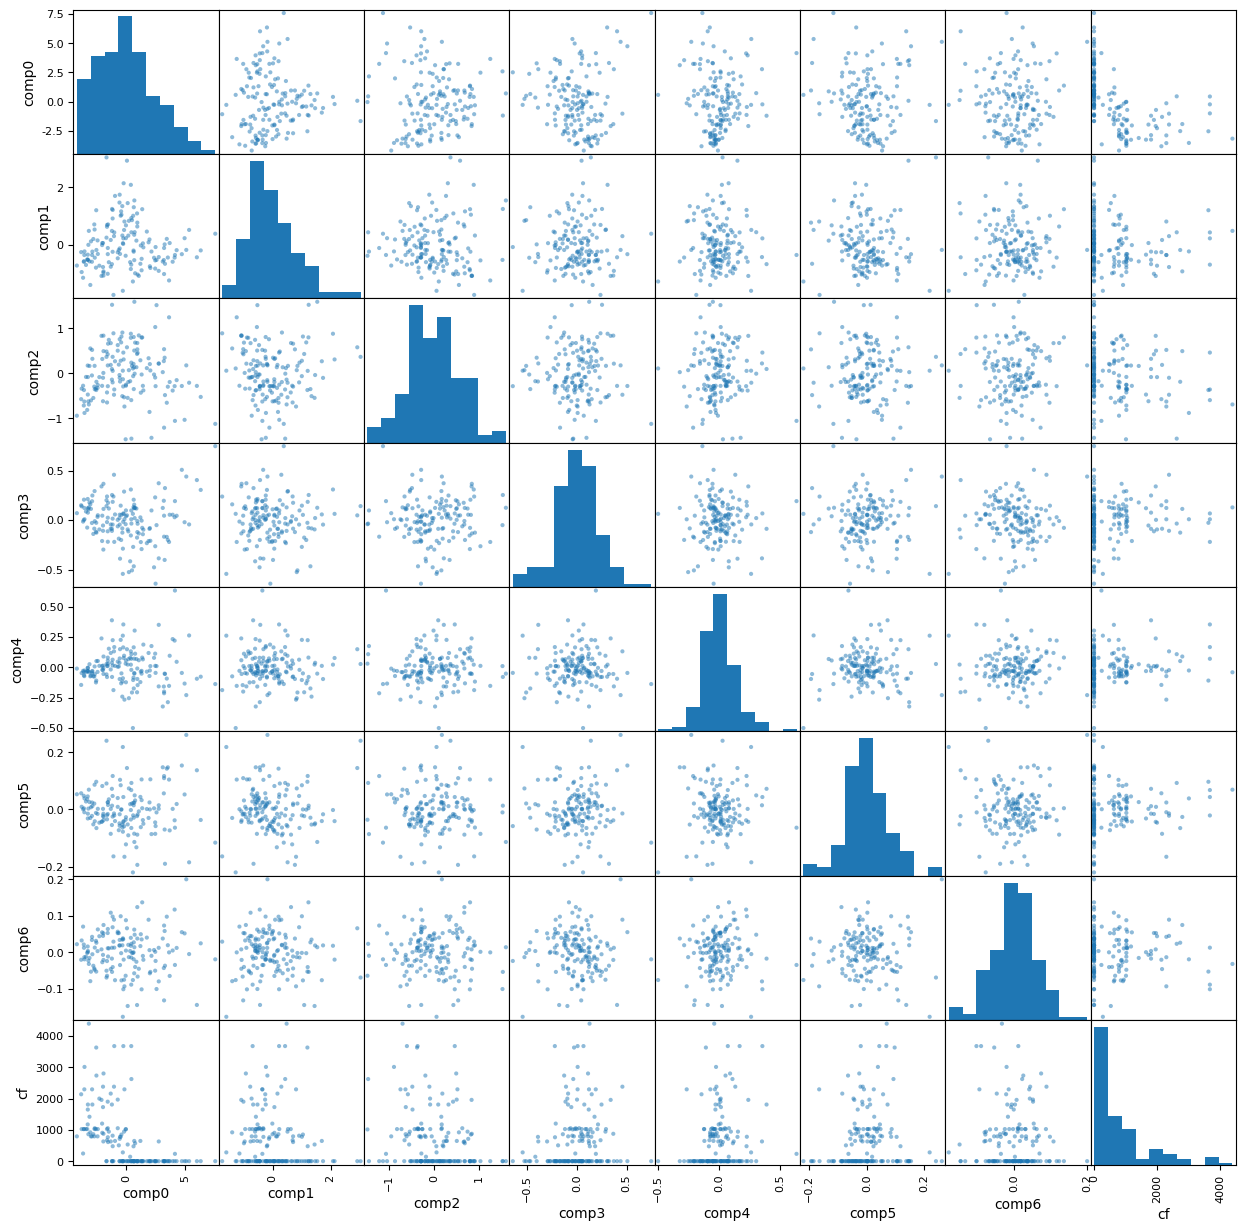

In [26]:
#look at scatter plot matrix of predictor variables
pd.plotting.scatter_matrix(tdf,figsize=(15,15))

### Look at the model fit

R squared =  0.31493852871694517
RMSE =  653.0035246421697


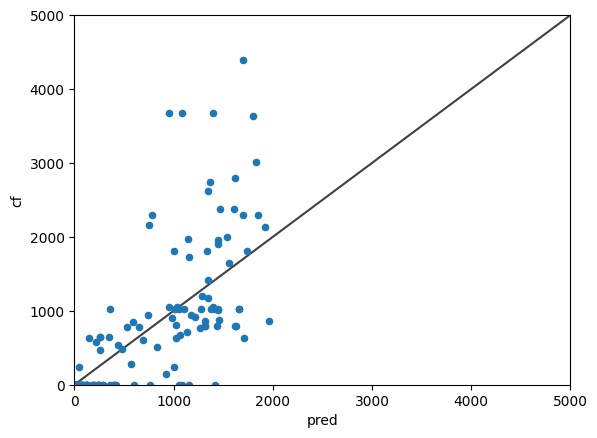

In [27]:
# Look at the oob
print('R squared = ',eknn.oob_score_)


# Calculate the RMSE and print
gdf['pred']=p
gdf['ste']=ste

print('RMSE = ',np.sqrt(((gdf['pred']-gdf['cf'])**2).mean()))

# Plot observed vs predicted
ax=gdf.plot.scatter(x='pred',y='cf',xlim=(0,5000),ylim=(0,5000))

# Create one to one line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Plot line on scatter plot
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

### Look at distribution of standard error

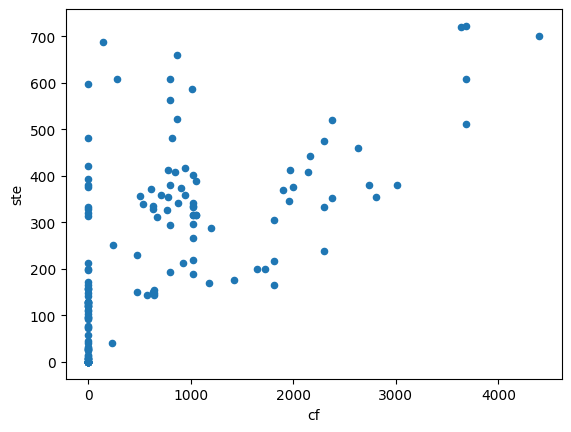

In [28]:
# Plot ste vs predicted
ax=gdf.plot.scatter(x='cf',y='ste',)

## Step 3: Use EKNN to create raster surfaces of mean CF/Acre and standard error of the mean CF/Acre.
### Estimate mean CF/Acre

In [29]:
# Read in landsat raster
pred_rs=Raster('ls8.tif')
# Transform landsat raster to components
pipe_a=general.ModelPredictAdaptor(pipe,'transform')
pred_tr=pred_rs.model_predict(pipe_a,X2.shape[1]).eval()
# Estimate mean CF
mcf=pred_tr.model_predict(eknn).eval()

### Estimate standard error of CF/Acre

In [30]:
# create a new function to estimate standard error
def ste(X):
    rslst=[]
    for e in eknn.estimators_:
        elst.append(e.predict(X))

    pdf=pd.DataFrame(elst)
    return pdf.std(axis=0)

# add the function to EKNN
eknn.ste=ste

# use the adapter to convert the new function into a Raster function
eknn_ste=general.ModelPredictAdaptor(eknn,'ste')

# Estimate standard error
stecf=pred_tr.model_predict(eknn_ste).eval()


### Plot mean CF/Acre

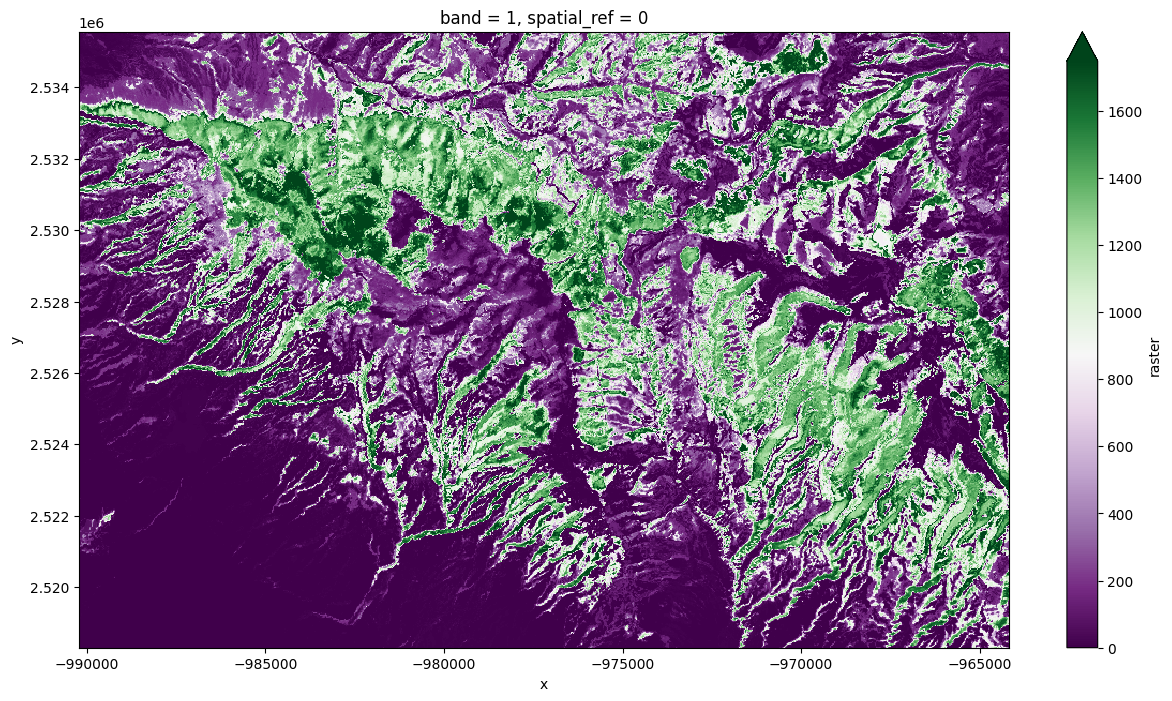

In [31]:
mcf.plot(figsize=(15,8),cmap='PRGn',robust=True)

### Plot Standard Error

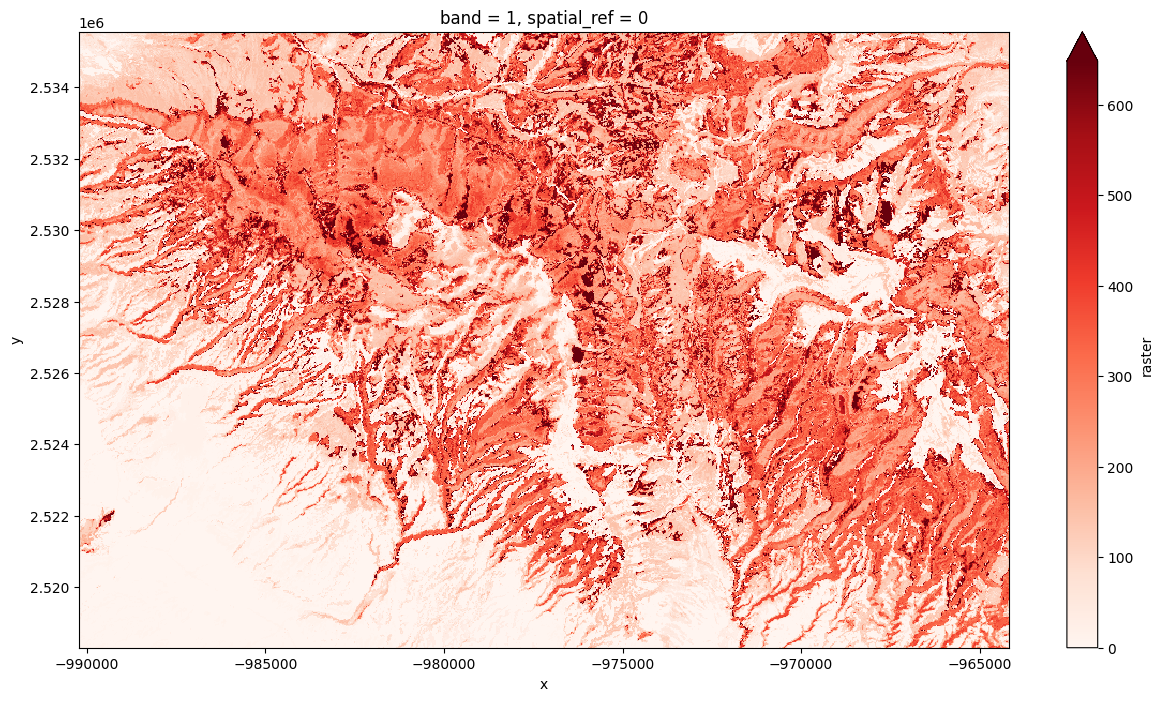

In [32]:
stecf.plot(figsize=(15,8),cmap='Reds',robust=True)

## Evaluate the Raster estimates
Look at the difference between observed and predicted values and determine RMSE

RMSE =  745.3774962775327


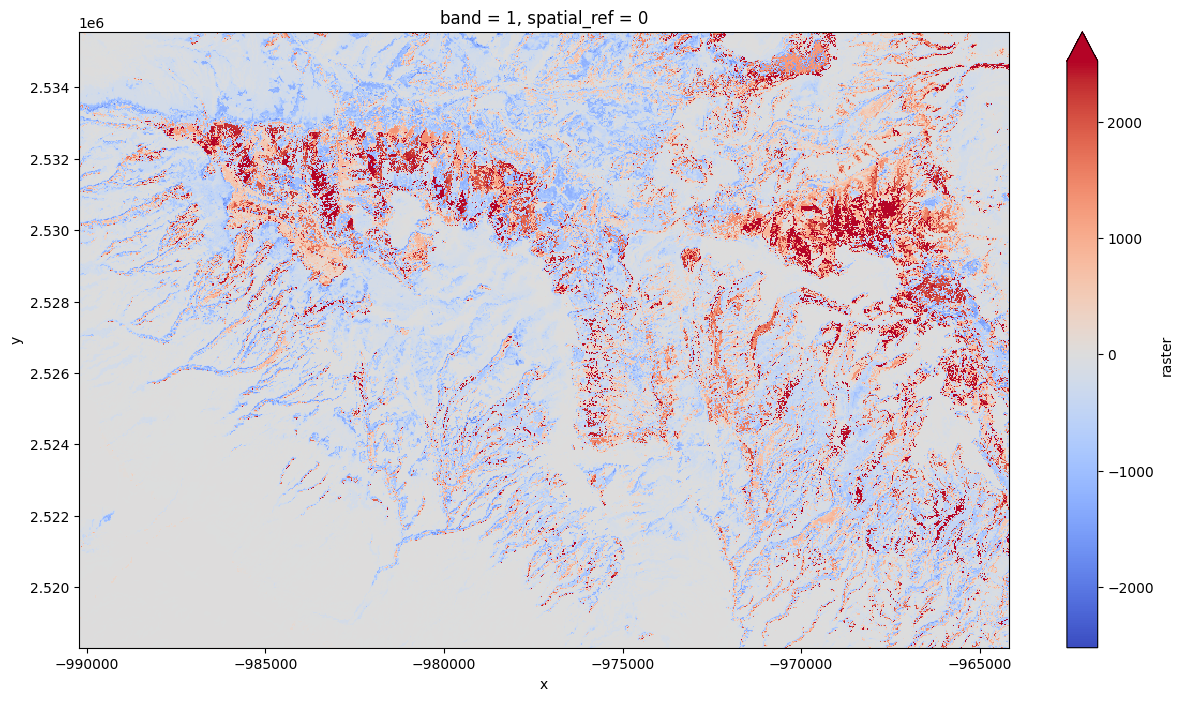

In [33]:
# Read in CF raster
cf_rs=Raster('cf1.tif')

# Reproject and snap to mcf raster
cf_rs=Raster(cf_rs.xdata.rio.reproject_match(mcf.xdata)).set_null_value(-99)

# Set null values to zero to match model assumption
cf_rs=cf_rs.where(~cf_rs.to_null_mask(),0)

# Subtract raster values
dif=cf_rs-mcf

#Calculate RMSE
rmse=np.sqrt((dif**2).mean()).compute()

#Print RMSE and the difference surface
print("RMSE = ",rmse)
dif.plot(figsize=(15,8),cmap='coolwarm',robust=True)

### Determine where mean falls within  95% CL

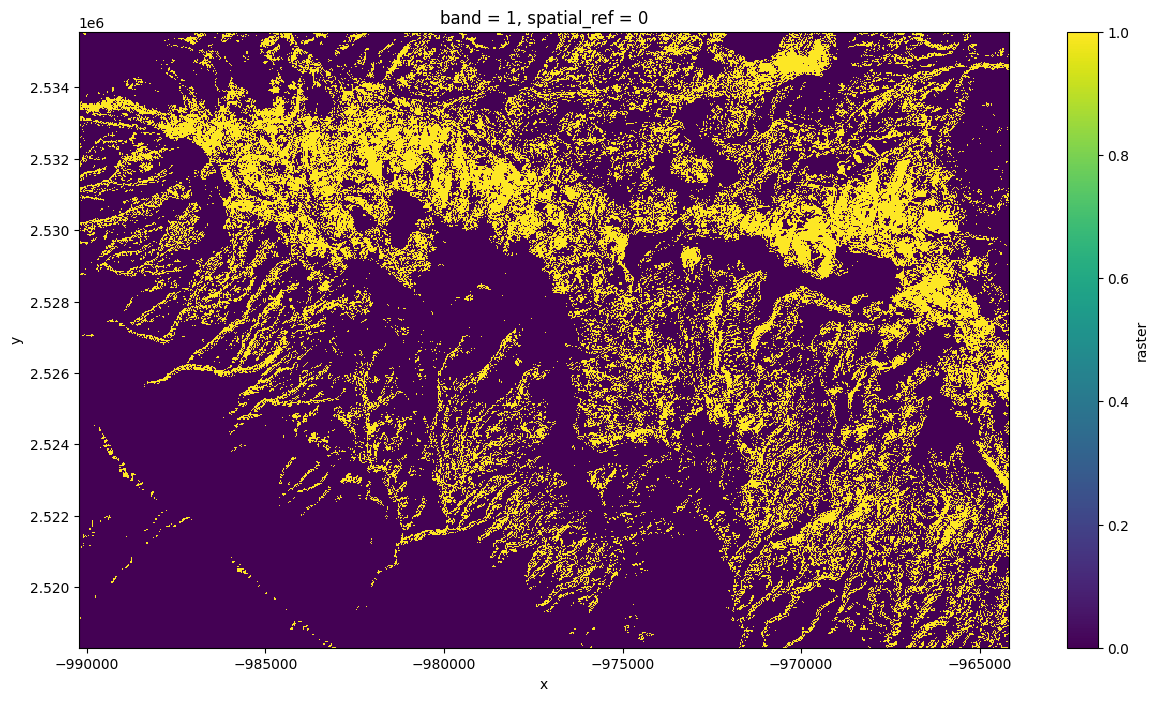

In [34]:
ch=(np.abs(dif)>(1.96*stecf))
ch.plot(figsize=(15,8))

## Compare population estimate to true value
### Using just the sample

In [35]:
import scipy

n=y.shape[0]
m=y.mean()
se=y.std()/np.sqrt(n)
tvl=scipy.stats.t.ppf(0.975,n-1)
t_p=clipping.clip(nf1p,cf_rs).mean().compute() #need to clip to nf1p study area boundary

print('Sample mean =',m)
print('Sample standard error =',se)
print('n =',n)
print('95% CL =',m-tvl*se,m+tvl*se)
print('True populaton mean =',t_p)


Sample mean = 697.3462580695467
Sample standard error = 77.68924411046608
n = 150
95% CL = 543.8312879433331 850.8612281957603
True populaton mean = 638.3576112161915


### Using the EKNN and component scores

In [101]:
# create a definition to calculate mean estimate for each KNN within the EKNN and store in a list
def get_sem(mdl,rs,clip=None):
  m_lst=[]
  for k in mdl.estimators_:
    est=rs.model_predict(k)
    if(clip is None):
      estc=est
    else:
      estc=clipping.clip(clip,est) #need to clip to nf1p study area boundary

    m_lst.append(estc.mean().compute())

  return m_lst

EKNN mean = 618.5722473970981
EKNN standard error = 55.30353624054183
n = 50
95% CL = [505.08089591 733.72366861]
True populaton mean = 638.3576112161915


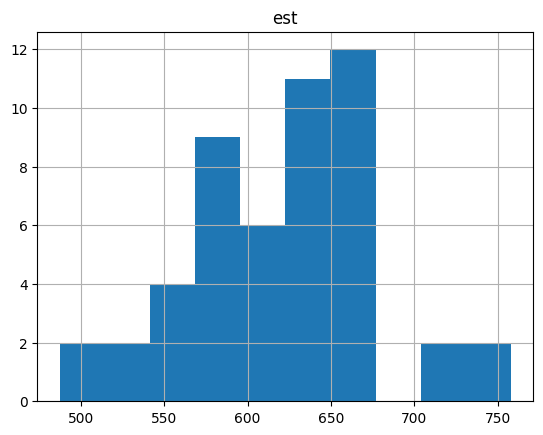

In [102]:
# Calculate estimates (mean and se) and graph distribution of ensemble
m_lst=get_sem(eknn,pred_tr,nf1p)
m2=np.mean(m_lst)
se2=np.std(m_lst)
n2=len(m_lst)

print('EKNN mean =',m2)
print('EKNN standard error =',se2)
print('n =', n2)
print('95% CL =',np.percentile(m_lst,[2.75,97.5]))
print('True populaton mean =',t_p)

# plot distribution of means for eknn
p=pd.DataFrame(m_lst,columns=['est']).hist()

## Outside the spatial domain

Desing Population estimate (cf/acre)= 697.3462580695467
EKNN Population estimate (cf/acre)=  528.3656012312607
EKNN Standard error estimate (cf/acre)= 48.20990212863937
True population value (cf/acre)=  544.171433061227


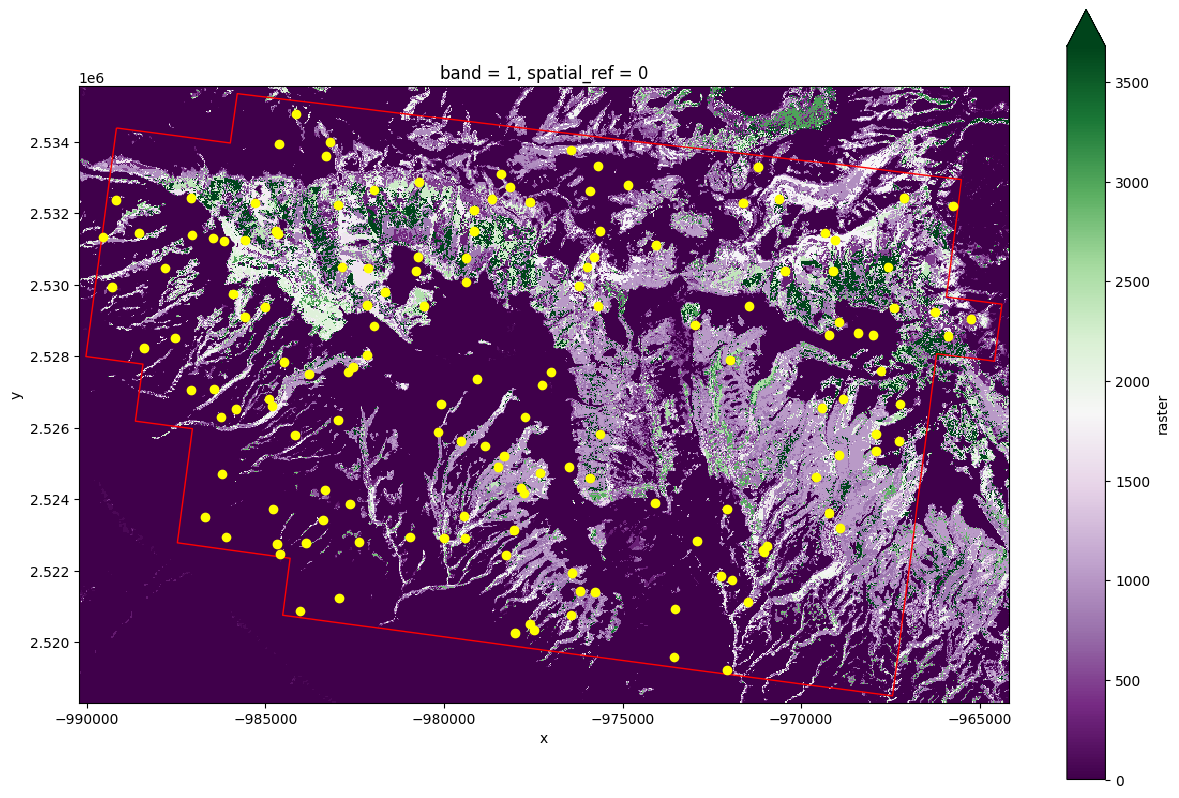

In [105]:
elst=get_sem(eknn,pred_tr)
print('Desing Population estimate (cf/acre)=',m)
print('EKNN Population estimate (cf/acre)= ',np.mean(elst))
print('EKNN Standard error estimate (cf/acre)=',np.std(elst))
print('True population value (cf/acre)= ', cf_rs.mean().compute())
p=nf1p.plot(facecolor="none",edgecolor='red',figsize=(15,10),zorder=1)
p=gdf.plot(ax=p,color='yellow',zorder=2)
p=cf_rs.plot(ax=p,cmap='PRGn',robust=True,zorder=0)


### Subarea within the spatial domain

Hectares = 5    78.413712
dtype: float64


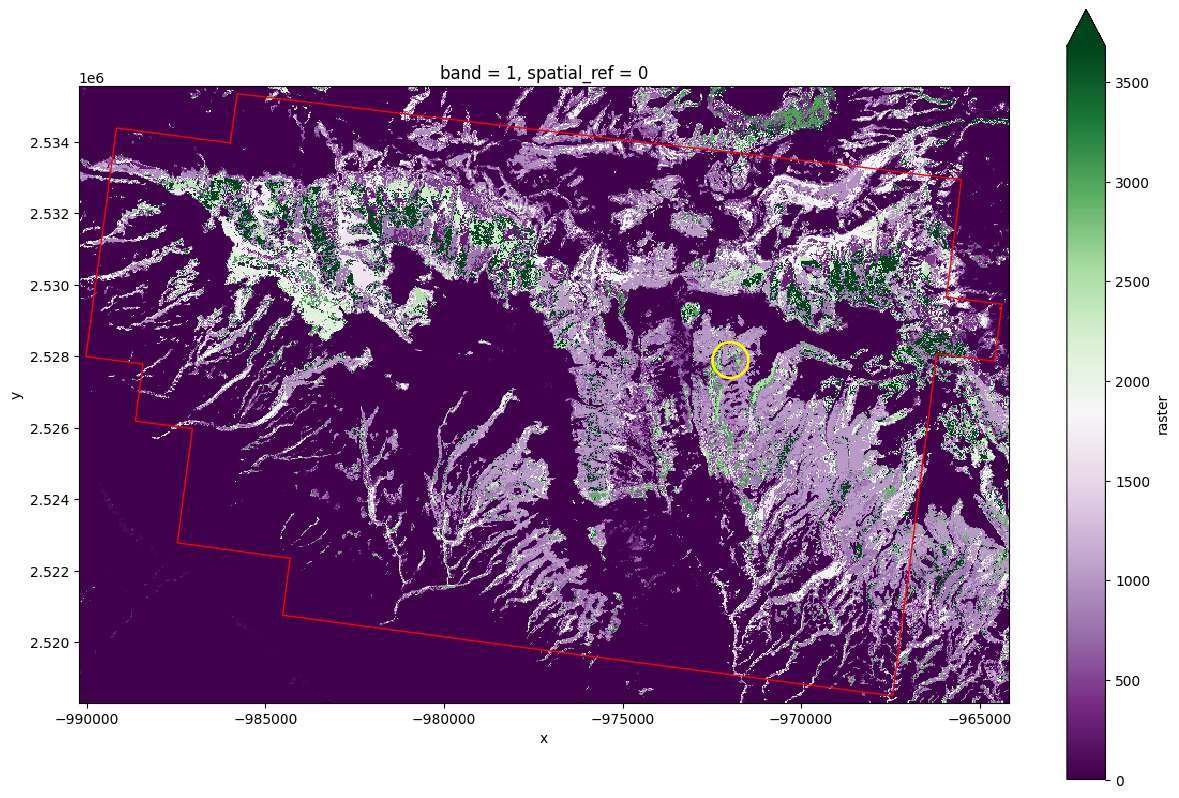

In [124]:
#use one of the plot locations and buffer out to approximately 78 ha to make a operational stand
stnd=gdf.iloc[5:6,:].buffer(500)
p=stnd.plot(facecolor="none",edgecolor='yellow',linewidth=2,zorder=2,figsize=(15,10))
p=nf1p.plot(ax=p, facecolor="none",edgecolor='red',zorder=1)
p=cf_rs.plot(ax=p,cmap='PRGn',robust=True,zorder=0)
print('Hectares =',stnd.area/10000)

In [119]:
tcf=clipping.clip(stnd,cf_rs).mean().compute()
elst=get_sem(eknn,pred_tr,stnd)

In [121]:
ecf=np.mean(elst)
ecfse=np.std(elst)
print('Sample mean =',(gdf[gdf.intersects(stnd.unary_union)]['cf']).mean())
print('Estimated mean CF =',ecf)
print('Estimated 95% CL (CF/Acre) =',np.percentile(elst,[2.75,97.5]))
print('True mean CF =',tcf)

Sample mean = 532.281237928
Estimated mean CF = 1068.812689643146
Estimated 95% CL (CF/Acre) = [ 866.26656819 1285.65691092]
True mean CF = 1298.6237952544395
